In [8]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from kf_book.book_plots import plot_filter, plot_measurements, set_labels
from numpy import array, asarray
import numpy.random as random
from numpy.random import randn
import matplotlib.pyplot as plt

zs shape: (99,)
std: 0.523


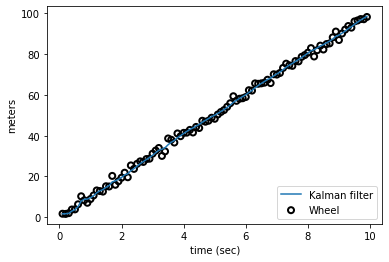

In [9]:
dt = 0.1
wheel_sigma = 1.5
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = array([[1., dt], [0., 1.]])
kf.H = array([[1., 0.]])
kf.x = array([[0.], [1.]])
kf.Q *= 0.01
kf.P *= 100
kf.R[0, 0] = wheel_sigma**2

random.seed(1123)
nom = range(1, 100)
zs = np.array([i + randn()*wheel_sigma for i in nom]);print(f'zs shape: {zs.shape}')
xs, _, _, _ = kf.batch_filter(zs)
ts = np.arange(0.1, 10, .1)

res = nom - xs[:, 0, 0]
print(f'std: {np.std(res):.3f}')

plot_filter(ts, xs[:, 0], label='Kalman filter')
plot_measurements(ts, zs, label='Wheel')
set_labels(x='time (sec)', y='meters')
plt.legend(loc=4);

### Kf for single lidar data

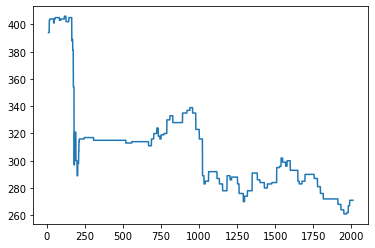

In [10]:
import pandas as pd
df = pd.read_csv('../../soltrek/lidar-plane-approximation/12june22-o-inv13-cb3.csv')
dff = df['or1']
tillRow = 2000
roi = df[(dff<9997)]['or1'][1:tillRow] # row of interest
data = np.array(roi.to_list())
plt.plot(roi)

zs shape: (1999,)
std: 10.511


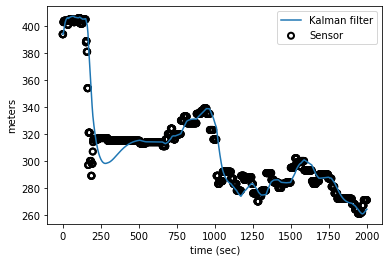

In [11]:
dt = 0.1 #100ms duration delay for sensor feed 
zSigma = np.std(data)
zInit = data[0]
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = array([[1., dt], [0., 1.]])
kf.H = array([[1., 0.]])
kf.x = array([[zInit], [0.1]])
kf.Q *= 0.01 # noise
kf.P *= 100 # arbitary for now
kf.R[0, 0] = zSigma**2

zs = data;print(f'zs shape: {zs.shape}')
xs, _, _, _ = kf.batch_filter(zs)
ts = np.arange(0.1, len(data))

res = zs - xs[:, 0, 0]
print(f'std: {np.std(res):.3f}')

plot_filter(ts, xs[:, 0], label='Kalman filter')
plot_measurements(ts, zs, label='Sensor')
set_labels(x='time (sec)', y='meters')
plt.legend(loc='best')

### The raw implementation

last cov: 86.15056148532422


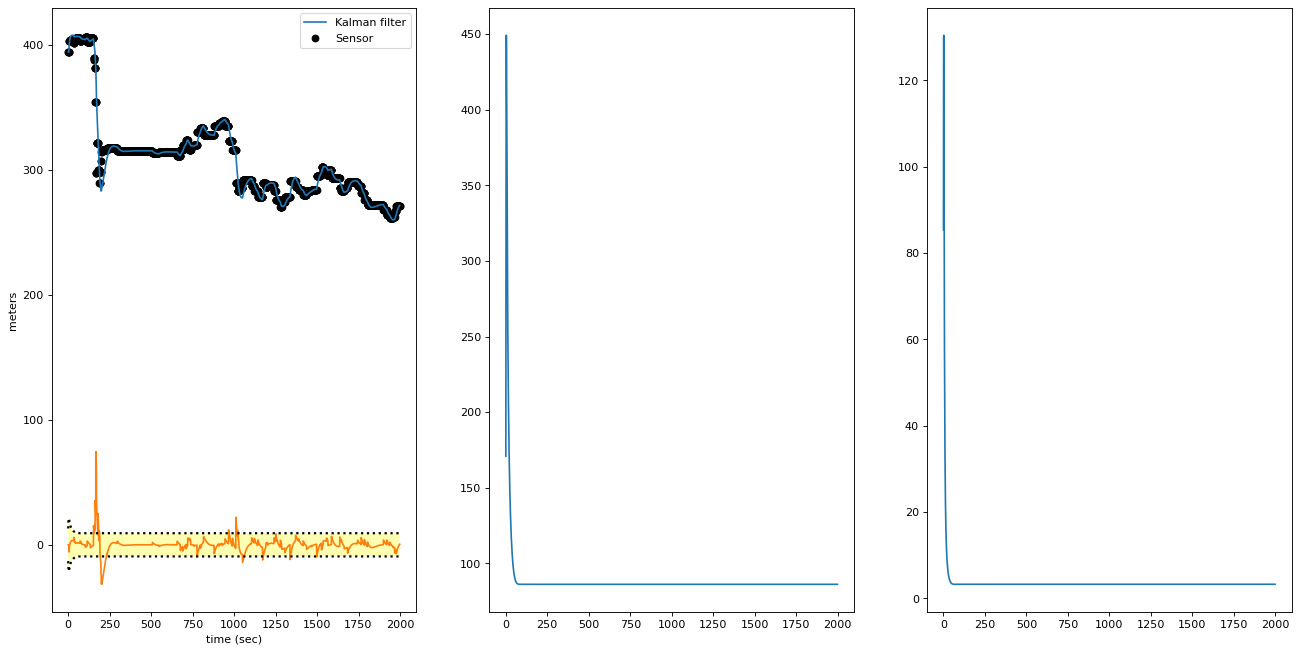

In [12]:
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track

dt = 1.
R_var = zSigma**2
Q_var = 0.01
x = np.array([[zInit, 0.1]]).T
P = np.diag([100, 100]) # arbitrary
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)
print('last cov:', cov[-1][0,0])

xs, cov = np.array(xs), np.array(cov)
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,3,1)
plt.plot(ts, xs[:, 0], label='Kalman filter') #xs[:, 0] for x and xs[:, 1] for v
plt.scatter(ts, zs, label='Sensor',color='k')
set_labels(x='time (sec)', y='meters')
plt.legend(loc='best');

# plot residuals 
resi = xs[:, 0] - data.reshape(-1,1)
plt.plot(resi)
# plot the filter output and the variance
stds = 1
std = np.sqrt(cov[:,0,0]) * stds
plt.plot(-std, color='k', ls=':', lw=2)
plt.plot(std, color='k', ls=':', lw=2)
plt.fill_between(range(len(std)), -std, std,
             facecolor='#ffff00', alpha=0.3)

# plot covariances
plt.subplot(1,3,2)
plt.plot(cov[:,0,0],label='X var')
plt.subplot(1,3,3)
plt.plot(cov[:,0,1],label='V var')

### Multiple (2) redundant sensors

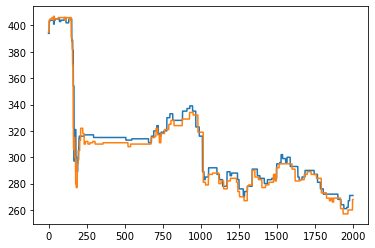

In [91]:
tillRow = 2000
dff = df[(df['or1']<9997) & 
        (df['or2']<9997)]
z1 = dff['or1'][1:tillRow] # row of interest
z2 = dff['or2'][1:tillRow] # row of interest
z1 = np.array(z1.to_list())
z2 = np.array(z2.to_list())
plt.plot(z1)
plt.plot(z2)

last cov: 51.75716801634269


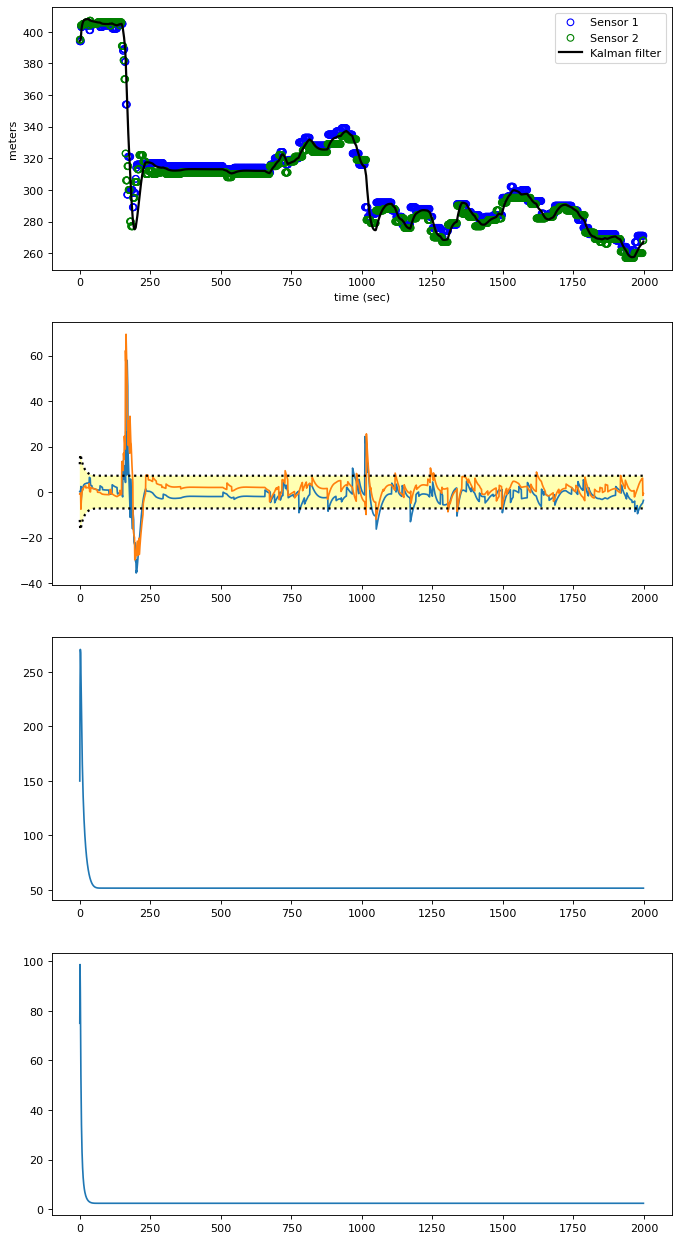

In [93]:
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track

dt = 1.
z1Sigma = np.std(z1)
z2Sigma = np.std(z2) # To be replaced with the std values computed using all bhatinda datasets

Q_var = 0.01
x = np.array([[z1[0], 0.1]]).T
P = np.diag([100, 100]) # arbitrary
F = np.array([[1., dt],
              [0,  1.]])
H = np.array([[1., 0.],
              [1., 0.]])
R = np.array([[z1Sigma**2, 0.1], # diagonals = 0.1= sensors' noise correlation (arbitrary)
              [0.1, z2Sigma**2]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

xs, cov = [], []
for za,zb in zip(z1,z2):
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = np.array([[za,zb]]).T - H @ x # sensor fusion/combination
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)
print('last cov:', cov[-1][0,0])

xs, cov = np.array(xs), np.array(cov)
plt.figure(figsize=(10, 20), dpi=80)
plt.subplot(4,1,1)
plt.autoscale(tight=False)
plt.scatter(ts, z1, label='Sensor 1',color='b',facecolor='none',lw=1)
plt.scatter(ts, z2, label='Sensor 2',color='g',facecolor='none',lw=1)
plt.plot(ts, xs[:, 0], label='Kalman filter',color='k',lw=2) #xs[:, 0] for x and xs[:, 1] for v
set_labels(x='time (sec)', y='meters')
plt.legend(loc='best');

# plot residuals 
resi1 = xs[:, 0] - z1.reshape([-1,1])
resi2 = xs[:, 0] - z2.reshape([-1,1])
plt.subplot(4,1,2)
plt.plot(resi1,label='res_Z1')
plt.plot(resi2,label='res_Z2')

# plot the filter output and the variance
stds = 1
std = np.sqrt(cov[:,0,0]) * stds
plt.plot(-std, color='k', ls=':', lw=2)
plt.plot(std, color='k', ls=':', lw=2)
plt.fill_between(range(len(std)), -std, std,
             facecolor='#ffff00', alpha=0.3)

# plot covariances
plt.subplot(4,1,3)
plt.plot(cov[:,0,0],label='X var')
plt.subplot(4,1,4)
plt.plot(cov[:,0,1],label='V var')

### KF + gating of Z

last cov: 64.76679083116854


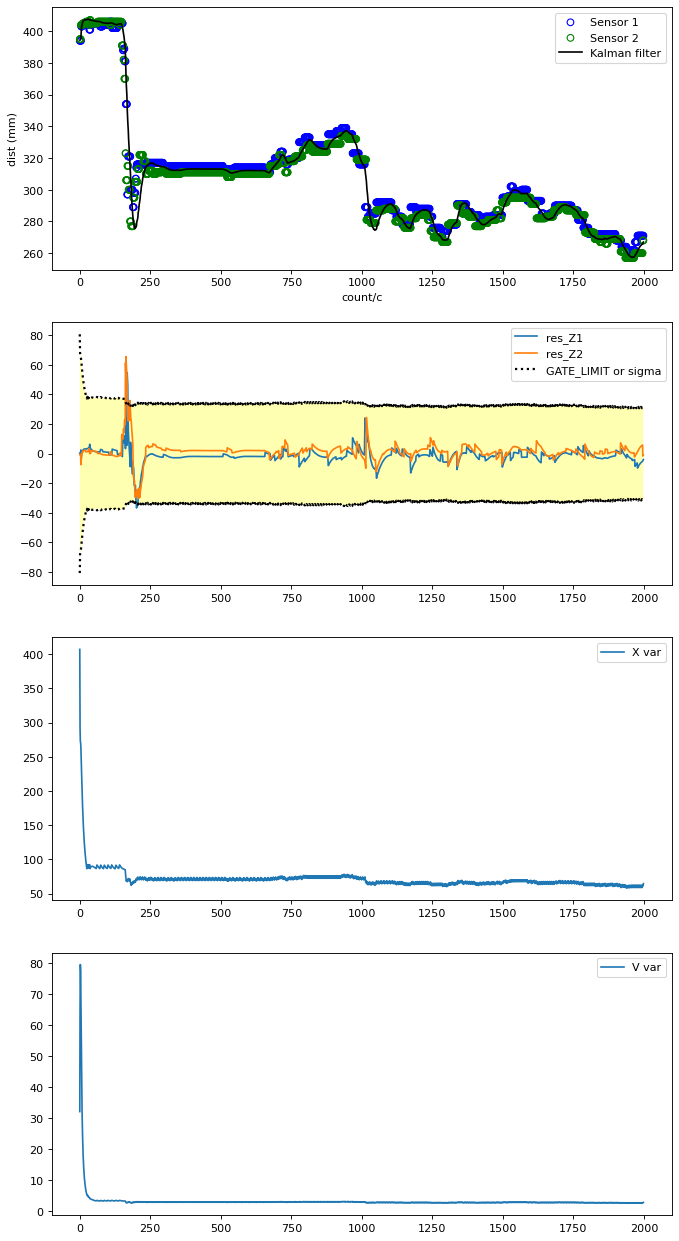

In [139]:
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track

dt = 1.
z1Sigma = np.std(z1) **2
z2Sigma = np.std(z2) **2# To be replaced with the std values computed using all bhatinda datasets

Q_var = 0.01
x = np.array([[zInit, 0.1]]).T
P = np.diag([z1Sigma, 100]) # arbitrary
F = np.array([[1., dt],
              [0,  1.]])
H = np.array([[1., 0.],
              [1., 0.]])
R = np.diag([z1Sigma,z2Sigma]) + 0.1
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

xs, cov = [], []
counter = []
Ks = []
count = -1
for za,zb in zip(z1,z2):
    count += 1
    
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    # filter Z
    stdX = P[0,0]
    GATE_LIMIT = 4
    if(za > GATE_LIMIT * stdX and zb > GATE_LIMIT * stdX):
        #print("Rejected Z= ",za,zb)
        continue
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = np.array([[za,zb]]).T - H @ x # sensor fusion/combination
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)
    Ks.append(K)
    counter.append(count)
    
print('last cov:', cov[-1][0,0])

xs, cov = np.array(xs), np.array(cov)
plt.figure(figsize=(10, 20), dpi=80)
plt.subplot(4,1,1)
plt.autoscale(tight=False)
plt.scatter(ts, z1, label='Sensor 1',color='b',facecolor='none',lw=1)
plt.scatter(ts, z2, label='Sensor 2',color='g',facecolor='none',lw=1)
plt.plot(counter, xs[:, 0], label='Kalman filter',color='k') #xs[:, 0] for x and xs[:, 1] for v
set_labels(x='count/c', y='dist (mm)')
plt.legend(loc='best');

# plot residuals 
resi1 = xs[:, 0] - z1.reshape([-1,1])[counter]
resi2 = xs[:, 0] - z2.reshape([-1,1])[counter]
plt.subplot(4,1,2)
plt.plot(counter, resi1,label='res_Z1')
plt.plot(counter, resi2,label='res_Z2')
# plot the filter output and the variance
stds = GATE_LIMIT
std = np.sqrt(cov[:,0,0]) * stds
plt.plot(counter, -std, color='k', ls=':', lw=2)
plt.plot(counter, std, color='k', ls=':', lw=2,label='GATE_LIMIT or sigma')
plt.legend(loc='best')
plt.fill_between(counter, -std, std,
             facecolor='#ffff00', alpha=0.3)

# plot covariances
plt.subplot(4,1,3)
plt.plot(counter, cov[:,0,0],label='X var')
plt.legend(loc='best')
plt.subplot(4,1,4)
plt.plot(counter, cov[:,0,1],label='V var')
plt.legend(loc='best')

In [78]:
# print last K
print(K)
'''
array([[0.15739587, 0.15739587],
       [0.00443671, 0.00443671]])
This shows that the 
'''
print(y.shape)

[[0.15739587 0.15739587]
 [0.00443671 0.00443671]]
(2, 1)


### 4 sensor fusion

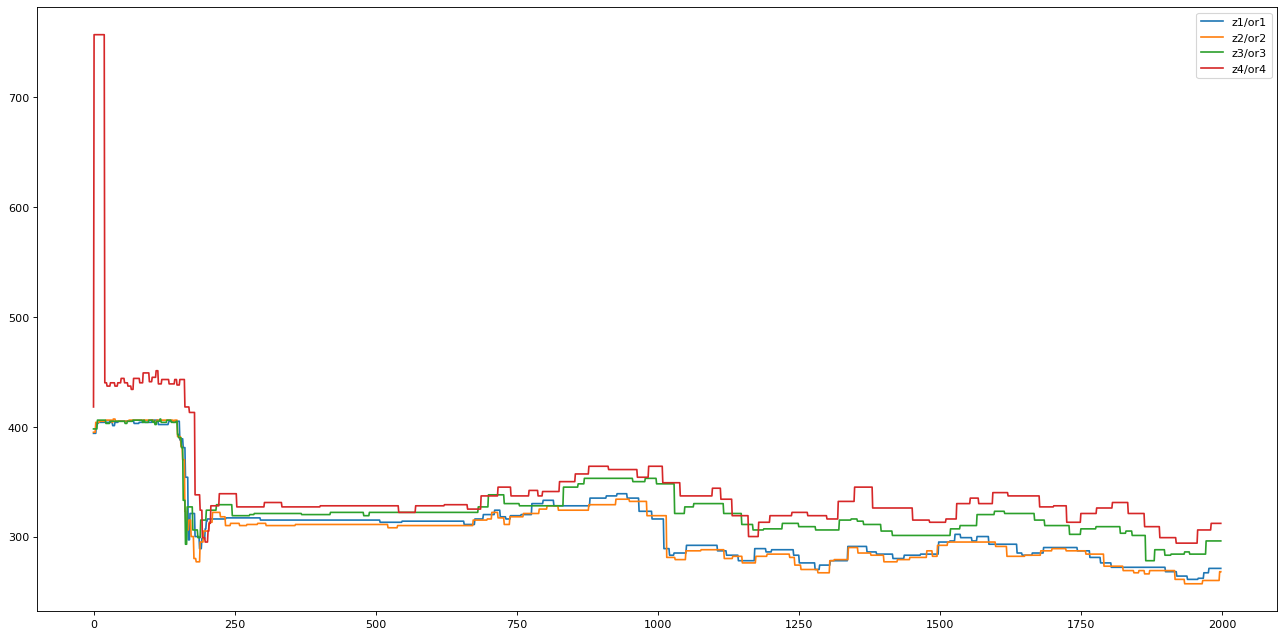

In [162]:
tillRow = 2000
dff = df[(df['or1']<9997) & 
        (df['or2']<9997) &
        (df['or3']<9997) &
        (df['or4']<9997)]
z1 = dff['or1'][1:tillRow] # row of interest
z2 = dff['or2'][1:tillRow] # row of interest
z3 = dff['or3'][1:tillRow]
z4 = dff['or4'][1:tillRow]

z1 = np.array(z1.to_list())
z2 = np.array(z2.to_list())
z3 = np.array(z3.to_list())
z4 = np.array(z4.to_list())

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(z1,label='z1/or1')
plt.plot(z2,label='z2/or2')
plt.plot(z3,label='z3/or3')
plt.plot(z4,label='z4/or4')
plt.legend(loc='best')

last cov: 93.06850671201425
K: [[0.07951225 0.07951225 0.1198674  0.03398332]
 [0.00280383 0.00280383 0.00422687 0.00119835]]
y: [[-10.78482993]
 [-21.78482993]
 [ 14.21517007]
 [ 30.21517007]]


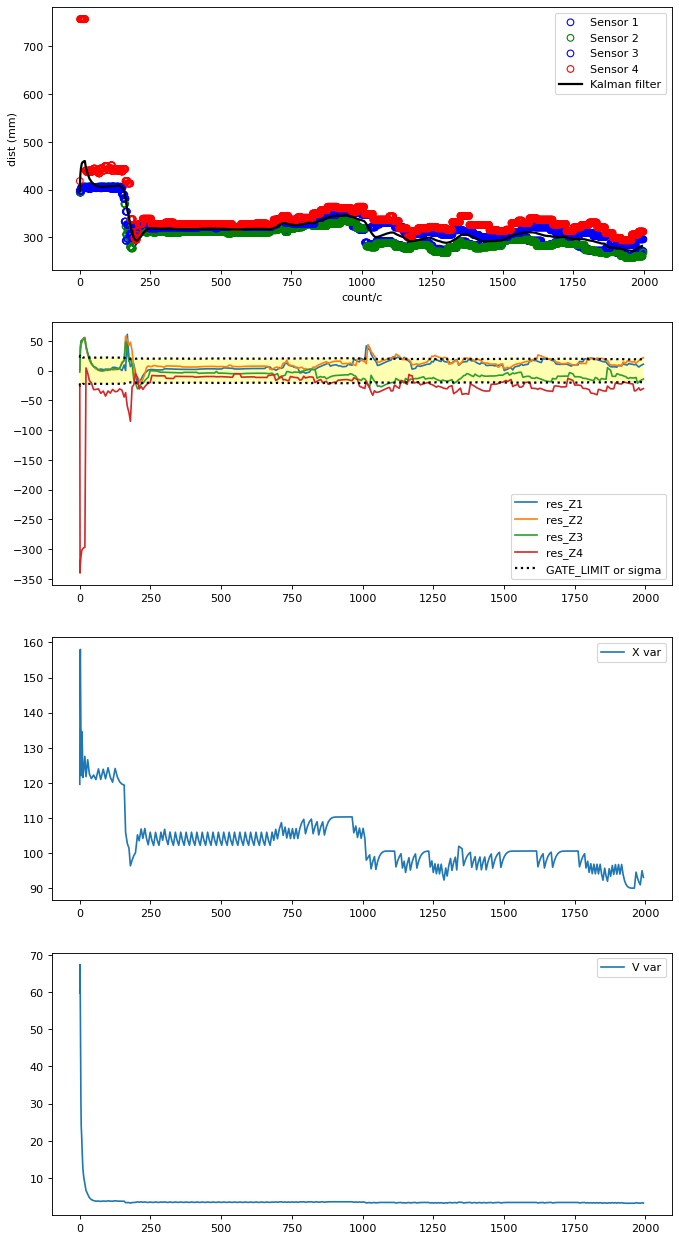

In [164]:
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track

dt = 1.
z1Sigma = np.std(z1) **2
z2Sigma = np.std(z1) **2 # To be replaced with the std values computed using all bhatinda datasets
z3Sigma = np.std(z3) **2
z4Sigma = np.std(z4) **2

Q_var = 0.01
x = np.array([[zInit, 0.1]]).T
P = np.diag([100, 100]) # arbitrary
F = np.array([[1., dt],
              [0,  1.]])
H = np.array([[1., 0.],
              [1., 0.],
              [1., 0.],
              [1., 0.],])

R = np.diag([z1Sigma,z2Sigma,z3Sigma,z4Sigma]) + 0.01

Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

xs, cov = [], []
counter = []
count = -1
for za,zb,zc,zd in zip(z1,z2,z3,z4):
    count += 1
    
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    # filter Z
    stdX = P[0,0]
    GATE_LIMIT = 2
    if(za > GATE_LIMIT * stdX and 
       zb > GATE_LIMIT * stdX and 
       zc > GATE_LIMIT * stdX and 
       zd > GATE_LIMIT * stdX
      ):
        #print("Rejected Z= ",za,zb)
        continue
        #pass
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = np.array([[za,zb,zc,zd]]).T - H @ x # sensor fusion/combination
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)
    counter.append(count)
    
print(f'last cov: {cov[-1][0,0]}\nK: {K}\ny: {y}')

xs, cov = np.array(xs), np.array(cov)
plt.figure(figsize=(10, 20), dpi=80)
plt.subplot(4,1,1)
plt.autoscale(tight=False)
plt.scatter(ts, z1, label='Sensor 1',color='b',facecolor='none',lw=1)
plt.scatter(ts, z2, label='Sensor 2',color='g',facecolor='none',lw=1)
plt.scatter(ts, z3, label='Sensor 3',color='b',facecolor='none',lw=1)
plt.scatter(ts, z4, label='Sensor 4',color='r',facecolor='none',lw=1)

plt.plot(counter, xs[:, 0], label='Kalman filter',color='k',lw=2) #xs[:, 0] for x and xs[:, 1] for v
set_labels(x='count/c', y='dist (mm)')
plt.legend(loc='best');

# plot residuals 
resi1 = xs[:, 0] - z1.reshape([-1,1])[counter]
resi2 = xs[:, 0] - z2.reshape([-1,1])[counter]
resi3 = xs[:, 0] - z3.reshape([-1,1])[counter]
resi4 = xs[:, 0] - z4.reshape([-1,1])[counter]
plt.subplot(4,1,2)
plt.plot(counter, resi1,label='res_Z1')
plt.plot(counter, resi2,label='res_Z2')
plt.plot(counter, resi3,label='res_Z3')
plt.plot(counter, resi4,label='res_Z4')

# plot the filter output and the variance
stds = GATE_LIMIT
std = np.sqrt(cov[:,0,0]) * stds
plt.plot(counter, -std, color='k', ls=':', lw=2)
plt.plot(counter, std, color='k', ls=':', lw=2,label='GATE_LIMIT or sigma')
plt.legend(loc='best')
plt.fill_between(counter, -std, std,
             facecolor='#ffff00', alpha=0.3)

# plot covariances
plt.subplot(4,1,3)
plt.plot(counter, cov[:,0,0],label='X var')
plt.legend(loc='best')
plt.subplot(4,1,4)
plt.plot(counter, cov[:,0,1],label='V var')
plt.legend(loc='best')

This is bad. As the 2 pairs (ol1, ol2) & (ol3, ol4) have a spatial shift leading to a temporal shift effect on the data. 

### KF class

In [150]:
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track

class kf():
    def __init__(self,z1Sigma,z2Sigma):
        dt = 1.
        self.z1Sigma = z1Sigma
        self.z2Sigma = z2Sigma
        
        self.Q_var = 0.01
        self.zInit = 300#(z1[0]+z2[0])*0.5
        self.x = np.array([[self.zInit, 0.1]]).T
        self.P = np.diag([self.z1Sigma, 100]) # arbitrary
        self.F = np.array([[1., dt],
                          [0,  1.]])
        self.H = np.array([[1., 0.],
                           [1., 0.]])
        self.R = np.diag([self.z1Sigma,self.z2Sigma]) + 0.1
        self.Q = Q_discrete_white_noise(dim=2, dt=dt, var=self.Q_var)

        self.xs, self.cov = [], []
        self.counter = []
        self.Ks = []
        self.count = -1
        self.GATE_LIMIT = 2
        self.zs = []
    
    def run(self,z1,z2):
        xs, cov = [], []
        for za,zb in zip(z1,z2):
            self.count += 1
            # predict
            self.x = self.F @ self.x
            self.P = self.F @ self.P @ self.F.T + self.Q

            # filter Z
            stdX = self.P[0,0]
            if(za > self.GATE_LIMIT * stdX and zb > self.GATE_LIMIT * stdX):
                #print("Rejected Z= ",za,zb)
                xs.append(np.array([[0, 0]]).T)
                cov.append(np.diag([0, 0]))
                continue
            #update
            self.S = self.H @ self.P @ self.H.T + self.R
            K = self.P @ self.H.T @ inv(self.S)
            y = np.array([[za,zb]]).T - self.H @ self.x # sensor fusion/combination
            self.x += K @ y
            self.P = self.P - K @ self.H @ self.P

            xs.append(self.x)
            cov.append(self.P)
            self.Ks.append(K)
            self.counter.append(count)
            
            #print('last cov:', cov[-1][0,0])
        self.xs = np.array(xs)
        self.cov = np.array(cov)
    
    def plot(self,z1,z2):
        xs, cov = np.array(self.xs), np.array(self.cov)
        plt.figure(figsize=(10, 20), dpi=80)
        plt.subplot(4,1,1)
        plt.autoscale(tight=False)
        plt.scatter(ts, z1, label='Sensor 1',color='b',facecolor='none',lw=1)
        plt.scatter(ts, z2, label='Sensor 2',color='g',facecolor='none',lw=1)
        plt.plot(xs[:, 0], label='Kalman filter',color='k') #xs[:, 0] for x and xs[:, 1] for v
        set_labels(x='count/c', y='dist (mm)')
        plt.legend(loc='best');

        # plot residuals 
        _z1 = z1[xs[:,0]==0] # making rejected Z = 0
        _z2 = z2[xs[:,0]==0]
        resi1 = xs[:, 0] - z1.reshape([-1,1])
        resi2 = xs[:, 0] - z2.reshape([-1,1])
        plt.subplot(4,1,2)
        plt.plot(resi1,label='res_Z1')
        plt.plot(resi2,label='res_Z2')
        # plot the filter output and the variance
        stds = GATE_LIMIT
        std = np.sqrt(cov[:,0,0]) * stds
        plt.plot(-std, color='k', ls=':', lw=2)
        plt.plot(std, color='k', ls=':', lw=2,label='GATE_LIMIT or sigma')
        plt.legend(loc='best')
        plt.fill_between(-std, std,
                     facecolor='#ffff00', alpha=0.3)

        # plot covariances
        plt.subplot(4,1,3)
        plt.plot(cov[:,0,0],label='X var')
        plt.legend(loc='best')
        plt.subplot(4,1,4)
        plt.plot(cov[:,0,1],label='V var')
        plt.legend(loc='best')

In [132]:

tillRow = 2000
dff = df[(df['or1']<9997) & 
        (df['or2']<9997)]
z1 = dff['or1'][1:tillRow] # row of interest
z2 = dff['or2'][1:tillRow] # row of interest
z1 = np.array(z1.to_list())
z2 = np.array(z2.to_list())


In [151]:
kf1 = kf(100,100)
kf1.run(z1,z2)
a = kf1.xs[:,0]
a[a==0].shape
#kf1.plot(z1,z2)

(1879,)

### Final comparison

In [167]:
df = pd.read_csv('../../soltrek/lidar-plane-approximation/28jun-o.csv')
dff = df[(df['or1']<9997) & 
        (df['or2']<9997) &
        (df['or3']<9997) &
        (df['or4']<9997) &
        (df['ol1']<9997) &
        (df['ol2']<9997) &
        (df['ol3']<9997) &
        (df['ol4']<9997)]

In [168]:
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track

def filter(z1,z2,z3,z4):
    dt = 1.
    z1Sigma = np.std(z1) **2
    z2Sigma = np.std(z1) **2 # To be replaced with the std values computed using all bhatinda datasets
    z3Sigma = np.std(z3) **2
    z4Sigma = np.std(z4) **2

    Q_var = 0.01
    x = np.array([[200, 0.1]]).T
    P = np.diag([z1Sigma, 100]) # arbitrary
    F = np.array([[1., dt],
                  [0,  1.]])
    H = np.array([[1., 0.],
                  [1., 0.],
                  [1., 0.],
                  [1., 0.],])

    R = np.diag([z1Sigma,z2Sigma,z3Sigma,z4Sigma]) + 0.01

    Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

    xs, cov = [], []
    counter = []
    count = -1
    for za,zb,zc,zd in zip(z1,z2,z3,z4):
        count += 1

        # predict
        x = F @ x
        P = F @ P @ F.T + Q

        # filter Z
        stdX = P[0,0]
        GATE_LIMIT = 2
        if(za > GATE_LIMIT * stdX and 
           zb > GATE_LIMIT * stdX and 
           zc > GATE_LIMIT * stdX and 
           zd > GATE_LIMIT * stdX
          ):
            #print("Rejected Z= ",za,zb)
            continue
            #pass
        #update
        S = H @ P @ H.T + R
        K = P @ H.T @ inv(S)
        y = np.array([[za,zb,zc,zd]]).T - H @ x # sensor fusion/combination
        x += K @ y
        P = P - K @ H @ P

        xs.append(x)
        cov.append(P)
        counter.append(count)

    print(f'last cov: {cov[-1][0,0]}\nK: {K}\ny: {y}')

    xs, cov = np.array(xs), np.array(cov)
    plt.figure(figsize=(10, 20), dpi=80)
    plt.subplot(4,1,1)
    plt.autoscale(tight=False)
    plt.scatter(ts, z1, label='Sensor 1',color='b',facecolor='none',lw=1)
    plt.scatter(ts, z2, label='Sensor 2',color='g',facecolor='none',lw=1)
    plt.scatter(ts, z3, label='Sensor 3',color='b',facecolor='none',lw=1)
    plt.scatter(ts, z4, label='Sensor 4',color='r',facecolor='none',lw=1)

    plt.plot(counter, xs[:, 0], label='Kalman filter',color='k',lw=2) #xs[:, 0] for x and xs[:, 1] for v
    set_labels(x='count/c', y='dist (mm)')
    plt.legend(loc='best');

    # plot residuals 
    resi1 = xs[:, 0] - z1.reshape([-1,1])[counter]
    resi2 = xs[:, 0] - z2.reshape([-1,1])[counter]
    resi3 = xs[:, 0] - z3.reshape([-1,1])[counter]
    resi4 = xs[:, 0] - z4.reshape([-1,1])[counter]
    plt.subplot(4,1,2)
    plt.plot(counter, resi1,label='res_Z1')
    plt.plot(counter, resi2,label='res_Z2')
    plt.plot(counter, resi3,label='res_Z3')
    plt.plot(counter, resi4,label='res_Z4')

    # plot the filter output and the variance
    stds = GATE_LIMIT
    std = np.sqrt(cov[:,0,0]) * stds
    plt.plot(counter, -std, color='k', ls=':', lw=2)
    plt.plot(counter, std, color='k', ls=':', lw=2,label='GATE_LIMIT or sigma')
    plt.legend(loc='best')
    plt.fill_between(counter, -std, std,
                 facecolor='#ffff00', alpha=0.3)

    # plot covariances
    plt.subplot(4,1,3)
    plt.plot(counter, cov[:,0,0],label='X var')
    plt.legend(loc='best')
    plt.subplot(4,1,4)
    plt.plot(counter, cov[:,0,1],label='V var')
    plt.legend(loc='best')

In [154]:
z1 = dff['or1'] # row of interest
z1 = np.array(z1.to_list())

array([0., 0., 0., ..., 0., 0., 0.])

### Threshold Voter

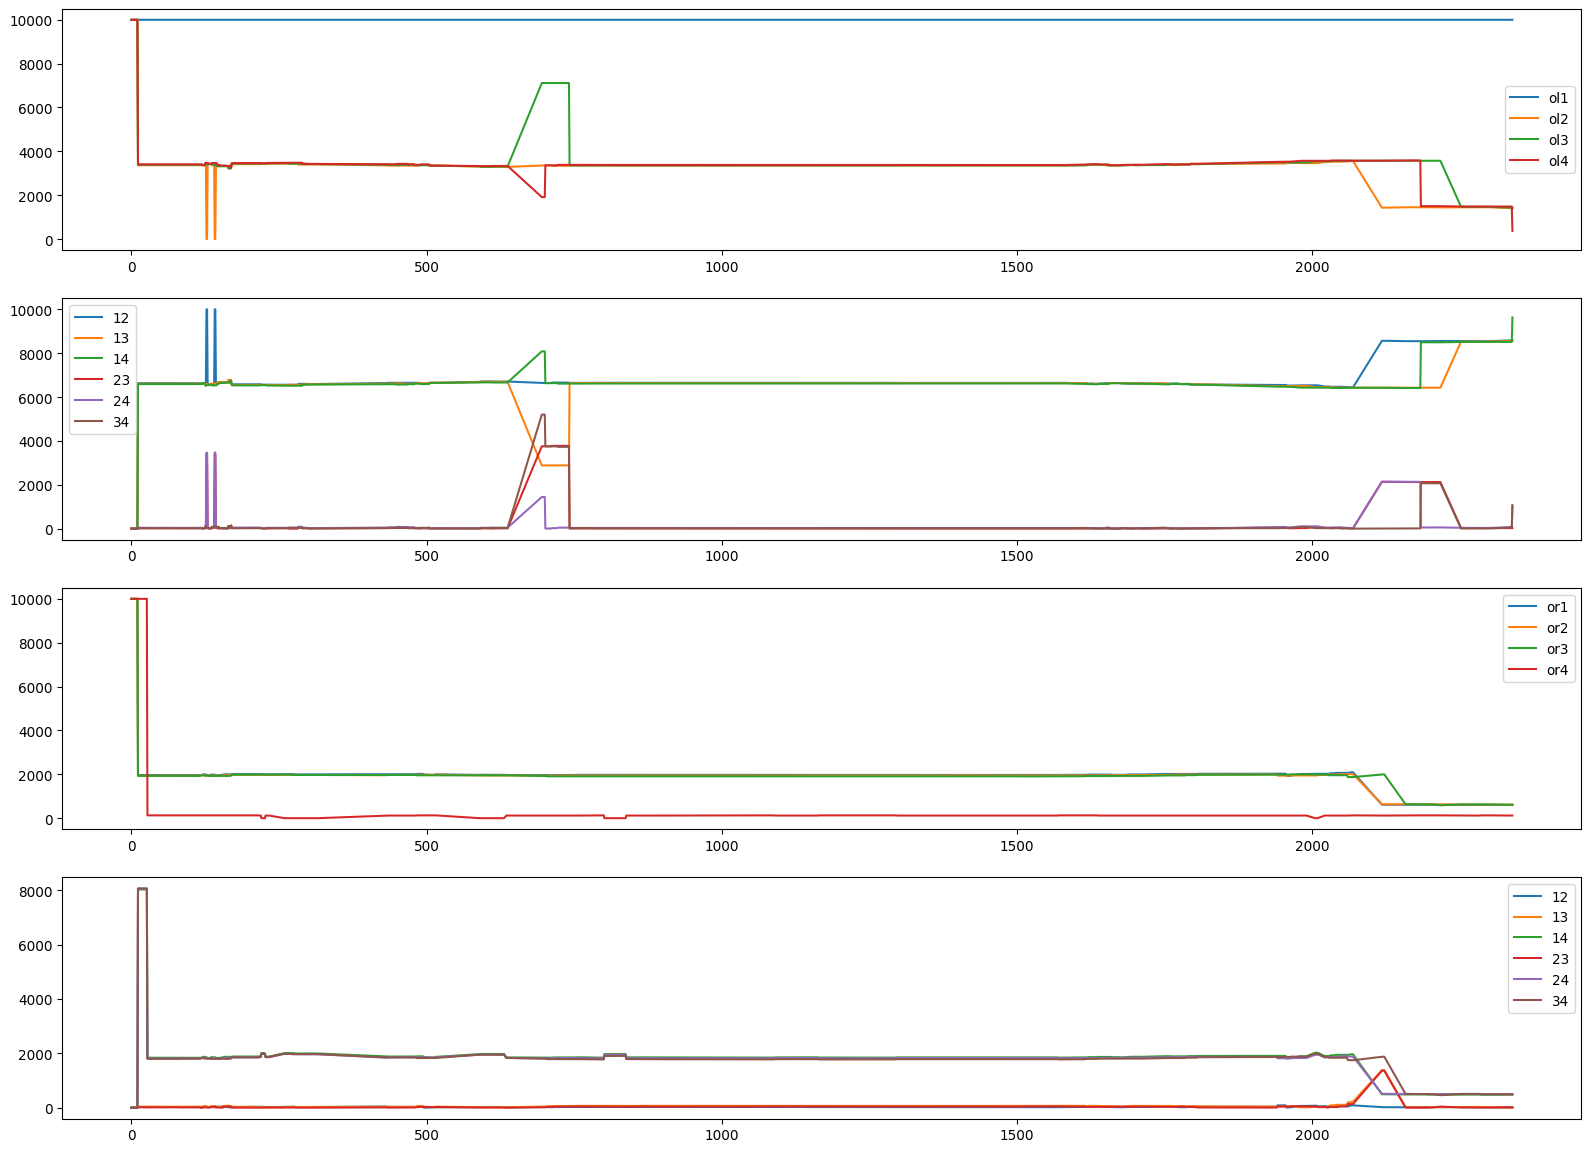

In [202]:
import pandas as pd
df = pd.read_csv('../../soltrek/lidar-plane-approximation/28jun-o.csv')
df = df[(df['or1']<9999) & 
        (df['or2']<9999) &
        (df['or3']<9999) &
        (df['or4']<9999) &
        (df['ol1']<9999) &
        (df['ol2']<9999) &
        (df['ol3']<9999) &
        (df['ol4']<9999)]


In [255]:
def plot_median_voter(df,plotFilter=False,top=[],bot=[]):
    plt.figure(figsize=(20,15),dpi=98)
    plt.subplot(4,1,1)
    counts = range(len(df['ol2']))
    plt.plot(counts,df['ol1'],label='ol1')
    plt.plot(counts,df['ol2'],label='ol2')
    plt.plot(counts,df['ol3'],label='ol3')
    plt.plot(counts,df['ol4'],label='ol4')
    if(plotFilter):
        plt.plot(counts,top,label='top',color='k')
    plt.legend(loc='best')
    # residuals
    plt.subplot(4,1,2)
    plt.plot(counts,abs(df['ol1']-df['ol2']),label='12')
    plt.plot(counts,abs(df['ol1']-df['ol3']),label='13')
    plt.plot(counts,abs(df['ol1']-df['ol4']),label='14')
    plt.plot(counts,abs(df['ol2']-df['ol3']),label='23')
    plt.plot(counts,abs(df['ol2']-df['ol4']),label='24')
    plt.plot(counts,abs(df['ol3']-df['ol4']),label='34')
    plt.legend(loc='best')

    plt.subplot(4,1,3)
    plt.plot(counts,df['or1'],label='or1')
    plt.plot(counts,df['or2'],label='or2')
    plt.plot(counts,df['or3'],label='or3')
    plt.plot(counts,df['or4'],label='or4')
    if(plotFilter):
        plt.plot(counts,bot,label='bot',color='k')
    plt.legend(loc='best')
    # residuals
    plt.subplot(4,1,4)
    plt.plot(counts,abs(df['or1']-df['or2']),label='12')
    plt.plot(counts,abs(df['or1']-df['or3']),label='13')
    plt.plot(counts,abs(df['or1']-df['or4']),label='14')
    plt.plot(counts,abs(df['or2']-df['or3']),label='23')
    plt.plot(counts,abs(df['or2']-df['or4']),label='24')
    plt.plot(counts,abs(df['or3']-df['or4']),label='34')
    plt.legend(loc='best')

In [275]:
# Filter
def median_voter(l1, l2, l3, l4, threshold):
    w1 = w2 = w3 = w4 = 0
    if(abs(l1-l2)<threshold):
        w1+=1; w2+=1
    if(abs(l1-l3)<threshold):
        w1+=1; w3+=1
    if(abs(l1-l4)<threshold):
        w1+=1; w4+=1
    if(abs(l2-l3)<threshold):
        w2+=1; w3+=1
    if(abs(l2-l4)<threshold):
        w2+=1; w4+=1
    if(abs(l3-l4)<threshold):
        w3+=1; w4+=1
    try:
        #print(w1, w2, w3, w4, w1+w2+w3+w4)
        avg = (w1*l1 + w2*l2 + w3*l3 + w4*l4)/(w1+w2+w3+w4)
    except Exception as e:
        print(e)
        avg = 0
    return avg

In [278]:
lidarTop, lidarBot = [], []
for i in range(len(df)):
    print('i= ',i)
    lidarTop.append(median_voter(df.iloc[i].ol1,
                                df.iloc[i].ol2,
                                df.iloc[i].ol3,
                                df.iloc[i].ol4,
                                1000))
    lidarBot.append(median_voter(df.iloc[i].or1,
                                df.iloc[i].or2,
                                df.iloc[i].or3,
                                df.iloc[i].or4,
                                1000))

i=  0
3 3 3 3 12
3 3 3 3 12
i=  1
3 3 3 3 12
3 3 3 3 12
i=  2
3 3 3 3 12
3 3 3 3 12
i=  3
3 3 3 3 12
3 3 3 3 12
i=  4
3 3 3 3 12
3 3 3 3 12
i=  5
3 3 3 3 12
3 3 3 3 12
i=  6
3 3 3 3 12
3 3 3 3 12
i=  7
3 3 3 3 12
3 3 3 3 12
i=  8
3 3 3 3 12
3 3 3 3 12
i=  9
3 3 3 3 12
3 3 3 3 12
i=  10
3 3 3 3 12
3 3 3 3 12
i=  11
0 2 2 2 6
2 2 2 0 6
i=  12
0 2 2 2 6
2 2 2 0 6
i=  13
0 2 2 2 6
2 2 2 0 6
i=  14
0 2 2 2 6
2 2 2 0 6
i=  15
0 2 2 2 6
2 2 2 0 6
i=  16
0 2 2 2 6
2 2 2 0 6
i=  17
0 2 2 2 6
2 2 2 0 6
i=  18
0 2 2 2 6
2 2 2 0 6
i=  19
0 2 2 2 6
2 2 2 0 6
i=  20
0 2 2 2 6
2 2 2 0 6
i=  21
0 2 2 2 6
2 2 2 0 6
i=  22
0 2 2 2 6
2 2 2 0 6
i=  23
0 2 2 2 6
2 2 2 0 6
i=  24
0 2 2 2 6
2 2 2 0 6
i=  25
0 2 2 2 6
2 2 2 0 6
i=  26
0 2 2 2 6
2 2 2 0 6
i=  27
0 2 2 2 6
2 2 2 0 6
i=  28
0 2 2 2 6
2 2 2 0 6
i=  29
0 2 2 2 6
2 2 2 0 6
i=  30
0 2 2 2 6
2 2 2 0 6
i=  31
0 2 2 2 6
2 2 2 0 6
i=  32
0 2 2 2 6
2 2 2 0 6
i=  33
0 2 2 2 6
2 2 2 0 6
i=  34
0 2 2 2 6
2 2 2 0 6
i=  35
0 2 2 2 6
2 2 2 0 6
i=  36
0 2 2 2 6

2 2 2 0 6
i=  315
0 2 2 2 6
2 2 2 0 6
i=  316
0 2 2 2 6
2 2 2 0 6
i=  317
0 2 2 2 6
2 2 2 0 6
i=  318
0 2 2 2 6
2 2 2 0 6
i=  319
0 2 2 2 6
2 2 2 0 6
i=  320
0 2 2 2 6
2 2 2 0 6
i=  321
0 2 2 2 6
2 2 2 0 6
i=  322
0 2 2 2 6
2 2 2 0 6
i=  323
0 2 2 2 6
2 2 2 0 6
i=  324
0 2 2 2 6
2 2 2 0 6
i=  325
0 2 2 2 6
2 2 2 0 6
i=  326
0 2 2 2 6
2 2 2 0 6
i=  327
0 2 2 2 6
2 2 2 0 6
i=  328
0 2 2 2 6
2 2 2 0 6
i=  329
0 2 2 2 6
2 2 2 0 6
i=  330
0 2 2 2 6
2 2 2 0 6
i=  331
0 2 2 2 6
2 2 2 0 6
i=  332
0 2 2 2 6
2 2 2 0 6
i=  333
0 2 2 2 6
2 2 2 0 6
i=  334
0 2 2 2 6
2 2 2 0 6
i=  335
0 2 2 2 6
2 2 2 0 6
i=  336
0 2 2 2 6
2 2 2 0 6
i=  337
0 2 2 2 6
2 2 2 0 6
i=  338
0 2 2 2 6
2 2 2 0 6
i=  339
0 2 2 2 6
2 2 2 0 6
i=  340
0 2 2 2 6
2 2 2 0 6
i=  341
0 2 2 2 6
2 2 2 0 6
i=  342
0 2 2 2 6
2 2 2 0 6
i=  343
0 2 2 2 6
2 2 2 0 6
i=  344
0 2 2 2 6
2 2 2 0 6
i=  345
0 2 2 2 6
2 2 2 0 6
i=  346
0 2 2 2 6
2 2 2 0 6
i=  347
0 2 2 2 6
2 2 2 0 6
i=  348
0 2 2 2 6
2 2 2 0 6
i=  349
0 2 2 2 6
2 2 2 0 6
i=  350
0 

/var/folders/3d/_9ftlcj54396cwckpfssmw_h0000gn/T/ipykernel_1010/3029729078.py:18: RuntimeWarning: invalid value encountered in long_scalars
  avg = (w1*l1 + w2*l2 + w3*l3 + w4*l4)/(w1+w2+w3+w4)


2 6
2 2 2 0 6
i=  482
0 2 2 2 6
2 2 2 0 6
i=  483
0 2 2 2 6
2 2 2 0 6
i=  484
0 2 2 2 6
2 2 2 0 6
i=  485
0 2 2 2 6
2 2 2 0 6
i=  486
0 2 2 2 6
2 2 2 0 6
i=  487
0 2 2 2 6
2 2 2 0 6
i=  488
0 2 2 2 6
2 2 2 0 6
i=  489
0 2 2 2 6
2 2 2 0 6
i=  490
0 2 2 2 6
2 2 2 0 6
i=  491
0 2 2 2 6
2 2 2 0 6
i=  492
0 2 2 2 6
2 2 2 0 6
i=  493
0 2 2 2 6
2 2 2 0 6
i=  494
0 2 2 2 6
2 2 2 0 6
i=  495
0 2 2 2 6
2 2 2 0 6
i=  496
0 2 2 2 6
2 2 2 0 6
i=  497
0 2 2 2 6
2 2 2 0 6
i=  498
0 2 2 2 6
2 2 2 0 6
i=  499
0 2 2 2 6
2 2 2 0 6
i=  500
0 2 2 2 6
2 2 2 0 6
i=  501
0 2 2 2 6
2 2 2 0 6
i=  502
0 2 2 2 6
2 2 2 0 6
i=  503
0 2 2 2 6
2 2 2 0 6
i=  504
0 2 2 2 6
2 2 2 0 6
i=  505
0 2 2 2 6
2 2 2 0 6
i=  506
0 2 2 2 6
2 2 2 0 6
i=  507
0 2 2 2 6
2 2 2 0 6
i=  508
0 2 2 2 6
2 2 2 0 6
i=  509
0 2 2 2 6
2 2 2 0 6
i=  510
0 2 2 2 6
2 2 2 0 6
i=  511
0 2 2 2 6
2 2 2 0 6
i=  512
0 2 2 2 6
2 2 2 0 6
i=  513
0 2 2 2 6
2 2 2 0 6
i=  514
0 2 2 2 6
2 2 2 0 6
i=  515
0 2 2 2 6
2 2 2 0 6
i=  516
0 2 2 2 6
2 2 2 0 6
i=  51

2 2 2 0 6
i=  815
0 2 2 2 6
2 2 2 0 6
i=  816
0 2 2 2 6
2 2 2 0 6
i=  817
0 2 2 2 6
2 2 2 0 6
i=  818
0 2 2 2 6
2 2 2 0 6
i=  819
0 2 2 2 6
2 2 2 0 6
i=  820
0 2 2 2 6
2 2 2 0 6
i=  821
0 2 2 2 6
2 2 2 0 6
i=  822
0 2 2 2 6
2 2 2 0 6
i=  823
0 2 2 2 6
2 2 2 0 6
i=  824
0 2 2 2 6
2 2 2 0 6
i=  825
0 2 2 2 6
2 2 2 0 6
i=  826
0 2 2 2 6
2 2 2 0 6
i=  827
0 2 2 2 6
2 2 2 0 6
i=  828
0 2 2 2 6
2 2 2 0 6
i=  829
0 2 2 2 6
2 2 2 0 6
i=  830
0 2 2 2 6
2 2 2 0 6
i=  831
0 2 2 2 6
2 2 2 0 6
i=  832
0 2 2 2 6
2 2 2 0 6
i=  833
0 2 2 2 6
2 2 2 0 6
i=  834
0 2 2 2 6
2 2 2 0 6
i=  835
0 2 2 2 6
2 2 2 0 6
i=  836
0 2 2 2 6
2 2 2 0 6
i=  837
0 2 2 2 6
2 2 2 0 6
i=  838
0 2 2 2 6
2 2 2 0 6
i=  839
0 2 2 2 6
2 2 2 0 6
i=  840
0 2 2 2 6
2 2 2 0 6
i=  841
0 2 2 2 6
2 2 2 0 6
i=  842
0 2 2 2 6
2 2 2 0 6
i=  843
0 2 2 2 6
2 2 2 0 6
i=  844
0 2 2 2 6
2 2 2 0 6
i=  845
0 2 2 2 6
2 2 2 0 6
i=  846
0 2 2 2 6
2 2 2 0 6
i=  847
0 2 2 2 6
2 2 2 0 6
i=  848
0 2 2 2 6
2 2 2 0 6
i=  849
0 2 2 2 6
2 2 2 0 6
i=  850
0 

3 3 3 3 12
i=  1148
0 0 1 1 2
3 3 3 3 12
i=  1149
0 0 1 1 2
3 3 3 3 12
i=  1150
0 0 1 1 2
3 3 3 3 12
i=  1151
0 0 1 1 2
3 3 3 3 12
i=  1152
0 0 1 1 2
3 3 3 3 12
i=  1153
0 0 1 1 2
3 3 3 3 12
i=  1154
0 1 0 1 2
3 3 3 3 12
i=  1155
0 1 0 1 2
3 3 3 3 12
i=  1156
0 1 0 1 2
3 3 3 3 12
i=  1157
0 1 0 1 2
3 3 3 3 12
i=  1158
0 1 0 1 2
3 3 3 3 12
i=  1159
0 1 0 1 2
3 3 3 3 12
i=  1160
0 1 0 1 2
3 3 3 3 12
i=  1161
0 1 0 1 2
3 3 3 3 12
i=  1162
0 1 0 1 2
3 3 3 3 12
i=  1163
0 1 0 1 2
3 3 3 3 12
i=  1164
0 1 0 1 2
3 3 3 3 12
i=  1165
0 1 0 1 2
3 3 3 3 12
i=  1166
0 1 0 1 2
3 3 3 3 12
i=  1167
0 1 0 1 2
3 3 3 3 12
i=  1168
0 1 0 1 2
3 3 3 3 12
i=  1169
0 1 0 1 2
3 3 3 3 12
i=  1170
0 1 0 1 2
3 3 3 3 12
i=  1171
0 1 0 1 2
3 3 3 3 12
i=  1172
0 1 0 1 2
3 3 3 3 12
i=  1173
0 1 0 1 2
3 3 3 3 12
i=  1174
0 1 0 1 2
3 3 3 3 12
i=  1175
0 2 2 2 6
3 3 3 3 12
i=  1176
0 2 2 2 6
3 3 3 3 12
i=  1177
0 2 2 2 6
3 3 3 3 12
i=  1178
0 2 2 2 6
3 3 3 3 12
i=  1179
0 2 2 2 6
3 3 3 3 12
i=  1180
0 2 2 2 6
3 3 3 3 12

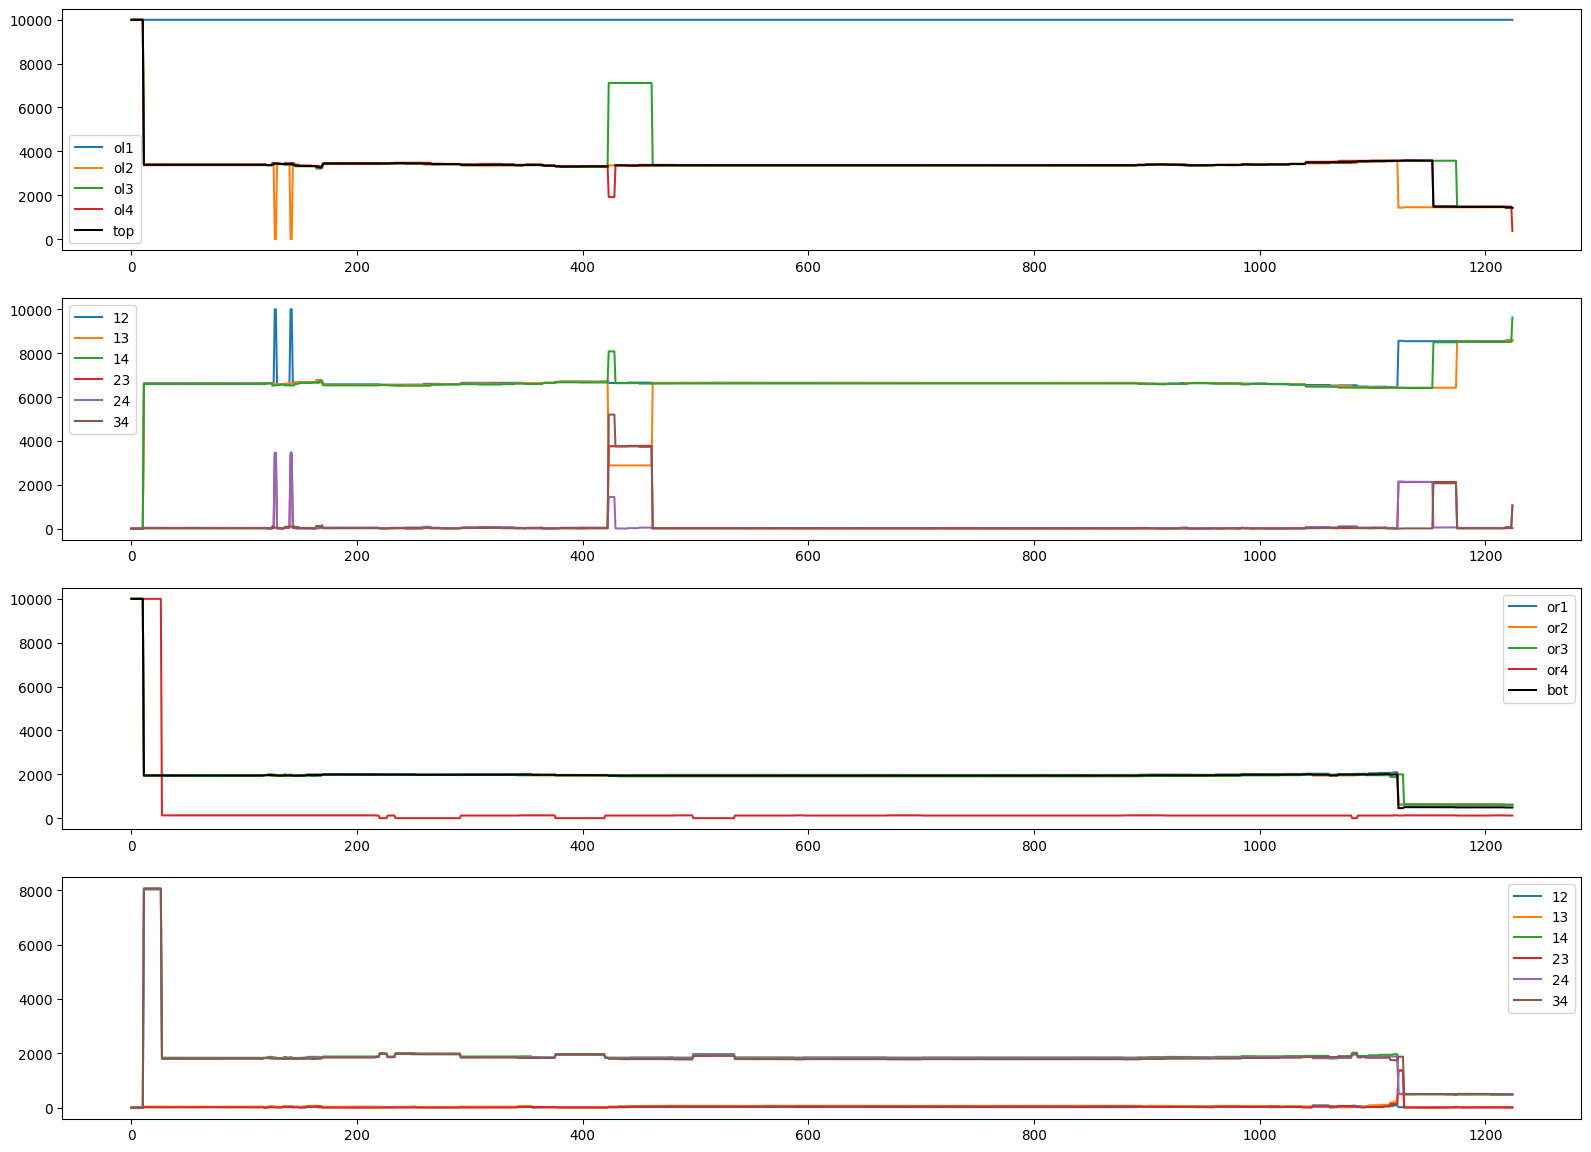

In [279]:
plot_median_voter(df,True,lidarTop,lidarBot)

In [270]:
df.iloc[430]

timestamp       1653059011.543679
c                               1
curr_phase           pre-cleaning
or1                          1962
or2                          1938
or3                          1919
or4                           120
ol1                          9998
ol2                          3359
ol3                          7115
ol4                          3368
oPE                             1
oPOG                            1
lidarStatus                normal
_logDuration               9998.0
_logError                    9998
Name: 702, dtype: object